In [1]:
import sys
import os
import SSGATE as ssgate
import scanpy as sc

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_cluster(adata_st, adata_sp, res1 = 0.2, res2 = 0.2, show_fig = True, figsize = (8,8)):
    print('Original ST Data Info: %d cells * %d genes.' % (adata_st.shape[0], adata_st.shape[1]))
#    adata_st.X = adata_st.X.astype(np.float)
#    sc.pp.highly_variable_genes(adata_st, flavor="seurat_v3", n_top_genes=3000)
#    adata_st =  adata_st[:, adata_st.var['highly_variable']]  
    sc.pp.normalize_total(adata_st, target_sum = 1e4)
#    sc.pp.normalize_per_cell(adata_st, target_sum=1e4)
    sc.pp.log1p(adata_st)  
#    sc.pp.scale(adata_st, max_value = 10)
    sc.pp.highly_variable_genes(adata_st, flavor="seurat_v3", n_top_genes=10000)
    adata_st =  adata_st[:, adata_st.var['highly_variable']] 
    sc.tl.pca(adata_st, n_comps=20)
    sc.pp.neighbors(adata_st)
    sc.tl.umap(adata_st)
    sc.tl.leiden(adata_st, resolution = 0.2, key_added = 'pre_label')

    print('Original SP Data Info: %d cells * %d genes.' % (adata_sp.shape[0], adata_sp.shape[1]))
    adata_sp.X = adata_sp.X.astype(np.float)
    adata_sp = ssgate.clr_normalization(adata_sp)
    sc.pp.neighbors(adata_sp)
    sc.pp.pca(adata_sp, n_comps=20)
    sc.tl.umap(adata_sp)
    sc.tl.leiden(adata_sp, resolution = 0.2, key_added = 'pre_label')

    if show_fig:
        fig, axs = plt.subplots(2, 2, figsize = figsize)
        sc.pl.umap(adata_st, color = "pre_label", s = 8, ax = axs[0, 0], show = False, title = "mRNA")
        sc.pl.umap(adata_sp, color = "pre_label", s = 8, ax = axs[0, 1], show = False, title = "Protein")
        sc.pl.spatial(adata_st, color = "pre_label", spot_size = 1.5, ax = axs[1, 0], show = False, title = "mRNA")
        sc.pl.spatial(adata_sp, color = "pre_label", spot_size = 1.5, ax = axs[1, 1], show = False, title = "Protein")
        fig.tight_layout(pad = 1.0)
        plt.show()

    return adata_st, adata_sp

In [3]:
# This tutorial is used to illustrate the steps of multi-omics integration of the SCS_MT dataset.
# Import transcriptome and proteome data in h5ad format
# adata_sp = sc.read_h5ad('SCS_MT_SP_bin50_filtered_raw.h5ad')
# adata_st = sc.read_h5ad('SCS_MT_ST_bin50_filtered_raw.h5ad')

adata_st = sc.read_h5ad("F:\liulin\E6\linliu\E6_ST_bin50_raw.h5ad")
adata_sp = sc.read_h5ad("F:\liulin\E6\linliu\E6_SP_bin50_raw.h5ad")

In [4]:
sc.pp.filter_genes(adata_st, min_cells=15)
sc.pp.filter_cells(adata_st, min_genes=120)
sc.pp.filter_genes(adata_sp, min_cells=15)
sc.pp.filter_cells(adata_sp, min_genes=30)

In [5]:
adata_sp = adata_sp.copy()

In [5]:
# adata_st.X = adata_st.X.toarray().astype(np.float32)
adata_sp.X = adata_sp.X.toarray().astype(np.float32)

In [6]:
adata_st = adata_st[adata_st.obs.index.isin(adata_sp.obs.index)]
adata_sp = adata_sp[adata_sp.obs.index.isin(adata_st.obs.index)]


Original ST Data Info: 19776 cells * 17603 genes.
Original SP Data Info: 19776 cells * 127 genes.
         Falling back to preprocessing with `sc.pp.pca` and default params.


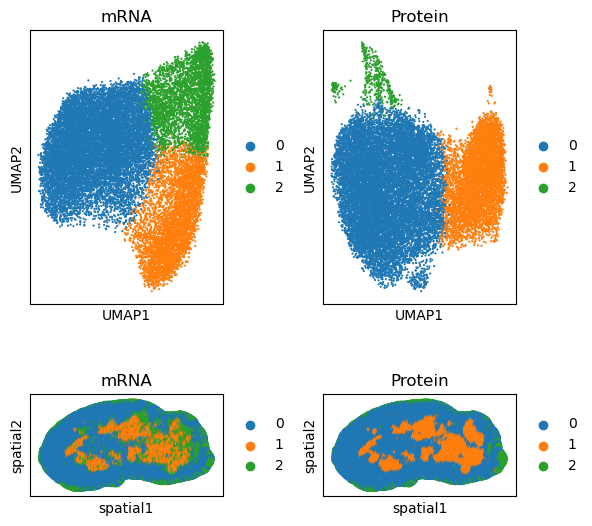

In [7]:
# The above data is not filtered or standardized by default, 
# and is preprocessed using the preprocessing function of SSGATE.
adata_st, adata_sp = ssgate.preprocess_cluster(adata_st, adata_sp, res_st = 0.2, res_sp = 0.2, show_fig = True, figsize = (6,6))

# adata_st, adata_sp = preprocess_cluster(adata_st, adata_sp, res1 = 0.2, res2 = 0.2, show_fig = True, figsize = (6,6))

In [8]:
adata_st1 = adata_st.copy()
adata_sp1 = adata_sp.copy()

In [9]:
adata_st.obsm['spatial'].dtype

dtype('int64')

------Calculating spatial graph...
The graph contains 296640 edges, 19776 cells.
15.0000 neighbors per cell on average.
++++++Pruning the spatial graph!++++++
296640 edges before pruning.
236006 edges after pruning.


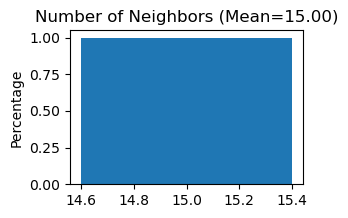

In [9]:
# Neighbor network construction, 
# network pruning, 
# and neighbor network statistics based on transcriptome data
adata_st = ssgate.Cal_Nbrs_Net(adata_st, feat = 'spatial', k_cutoff = 15, model = "KNN")
adata_st = ssgate.prune_net(adata_st)
ssgate.Stats_Nbrs_Net(adata_st)

------Calculating spatial graph...
The graph contains 296640 edges, 19776 cells.
15.0000 neighbors per cell on average.
++++++Pruning the spatial graph!++++++
296640 edges before pruning.
269597 edges after pruning.


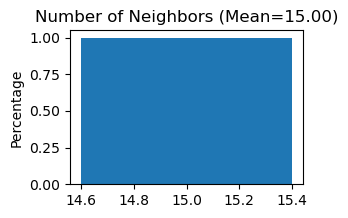

In [10]:
# Proteomic data are processed similarly to transcriptomic data
adata_sp = ssgate.Cal_Nbrs_Net(adata_sp, feat = 'spatial', k_cutoff = 15, model = "KNN")
adata_sp = ssgate.prune_net(adata_sp)
ssgate.Stats_Nbrs_Net(adata_sp)

In [11]:
sc.pp.pca(adata_st, n_comps=200)

  0%|          | 0/150 [00:00<?, ?it/s]

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6374073028564453 seconds
Jaccard graph constructed in 6.170526742935181 seconds
Wrote graph to binary file in 0.154998779296875 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79613
After 7 runs, maximum modularity is Q = 0.797824
Louvain completed 27 runs in 11.958213090896606 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 19.94705581665039 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.5409274101257324 seconds
Jaccard graph constructed in 2.650648593902588 seconds
Wrote graph to binary file in 0.14999961853027344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802916
After 9 runs, maximum modularity is Q = 0.805095
Louvain completed 29 runs in 8.868712902069092 seconds
Sorting communities by size, please wait ...
PhenoG

 33%|███▎      | 50/150 [12:18<23:34, 14.14s/it] 

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.48644566535949707 seconds
Jaccard graph constructed in 2.597621202468872 seconds
Wrote graph to binary file in 0.14859509468078613 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798397
After 2 runs, maximum modularity is Q = 0.801812
After 7 runs, maximum modularity is Q = 0.803465
After 26 runs, maximum modularity is Q = 0.804709
Louvain completed 46 runs in 20.94398283958435 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 25.166024208068848 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.49497413635253906 seconds
Jaccard graph constructed in 2.400097608566284 seconds
Wrote graph to binary file in 0.15036773681640625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.820361
After 6 runs, maximum modularity is Q = 0.822995
Lo

 67%|██████▋   | 100/150 [25:25<15:10, 18.21s/it]

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1941168308258057 seconds
Jaccard graph constructed in 2.623579740524292 seconds
Wrote graph to binary file in 0.18635821342468262 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.811477
After 8 runs, maximum modularity is Q = 0.812879
Louvain completed 28 runs in 12.658418655395508 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 17.662419080734253 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.18996000289917 seconds
Jaccard graph constructed in 2.4799818992614746 seconds
Wrote graph to binary file in 0.20062541961669922 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.836866
After 2 runs, maximum modularity is Q = 0.838669
After 5 runs, maximum modularity is Q = 0.841143
Louvain completed 25 runs in 7.616191148757935 seconds

100%|██████████| 150/150 [40:57<00:00, 16.38s/it]


Ploting losses!


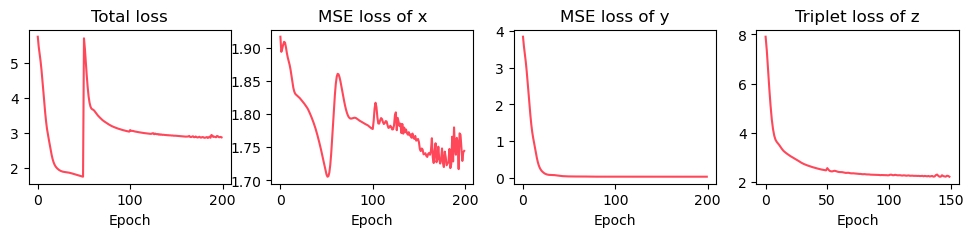

In [12]:
# After the nearest neighbor network is built, it is trained based on the above data, 
# and the integrated results obtained from the training are retained in the .obsm file of h5ad.
adata_st, adata_sp = ssgate.train(adata_st, adata_sp, 
                                    hidden_dims1 = 128, 
                                    hidden_dims2 = 128, 
                                    out_dims = 30, 
                                    cluster_update_epoch = 50, 
                                    epochs_init = 50, 
                                    n_epochs=200, 
                                    save_reconstrction=False, 
                                    sigma = 0.5, 
                                    device = "cuda:0", 
                                    feat1 = "PCA",
                                    key_added = 'ssgate_embed')

In [ ]:
## Save the data for Monocle3 pseudo-timing analysis as a csv file in advance
adata_st.to_df().to_csv('Monocle3_folder/expression_matrix.csv')
adata_st.obs.to_csv('Monocle3_folder/metadata.csv')
adata_st.var.to_csv('Monocle3_folder/gene_metadata.csv')
pd.DataFrame(adata_st.obsm['X_umap']).to_csv('Monocle3_folder/umap.csv')
pd.DataFrame(adata_st.obsm['ssgate_embed']).to_csv('Monocle3_folder/ssgate_embed.csv')

In [15]:
sc.pp.neighbors(adata_st, n_neighbors=25, use_rep = 'ssgate_embed', key_added = 'SSGATE_neighbor')
sc.tl.umap(adata_st, neighbors_key = 'SSGATE_neighbor')
sc.tl.leiden(adata_st, resolution=0.8, key_added='ssgate_cluster',neighbors_key='SSGATE_neighbor')

In [19]:
sc.tl.leiden(adata_st, resolution=0.75, key_added='ssgate_cluster',neighbors_key='SSGATE_neighbor')

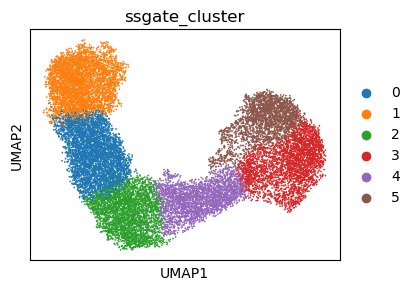

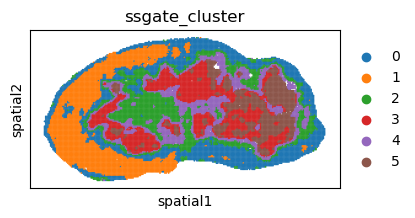

In [20]:
# Draw UMAP graph and resize and save
fig, ax = plt.subplots(figsize=(4, 3))
sc.pl.umap(adata_st, color='ssgate_cluster', ax=ax)
plt.title('UMAP of ssgate_cluster')
plt.savefig('umap_ssgate_cluster_custom.png', dpi=300)
plt.close()

# Draw the spatial map and resize and save
fig, ax = plt.subplots(figsize=(4, 3))
sc.pl.spatial(adata_st, color='ssgate_cluster', spot_size=1.5, ax=ax)
plt.title('Spatial Plot of ssgate_cluster')
plt.savefig('spatial_ssgate_cluster_custom.png', dpi=300)
plt.close()

In [21]:
# Statistics of differentially expressed genes based on clustering results
adata_st.uns['log1p'] = {'base': None}
sc.tl.rank_genes_groups(adata_st, groupby='ssgate_cluster')
result = adata_st.uns['rank_genes_groups']
celltype_list = adata_st.obs.ssgate_cluster.cat.categories.to_list()
df_all = pd.DataFrame({})

for i in range(len(celltype_list)):
    group = celltype_list[i]
    highly_expressed_genes = result['names'][group][:100]  # Get the top 100 genes
    confidence_scores = result['scores'][group][:100]  # Get the corresponding confidence
    pval = result['pvals'][group][:100]
    logfoldchange = result['logfoldchanges'][group][:100]
    
    # Merge arrays into a DataFrame
    df = pd.DataFrame({'Group': str(group), 'Gene_name': highly_expressed_genes, 'Confidence_scores': confidence_scores, 'Pval': pval, 'logfoldchanges': logfoldchange})

    # Set the index name for the DataFrame
    df.index.name = 'Index'
    print('Cell type : ', str(group))
    # Output results
    print(df)
    df_all = pd.concat([df_all, df], ignore_index=True)
# Result Output
df_all.to_csv('SSGATE_100DEgene_SCS_MT.csv')

Cell type :  0
      Group Gene_name  Confidence_scores           Pval  logfoldchanges
Index                                                                  
0         0      Rag1          23.540386  2.755883e-118        1.896446
1         0      Tcf7          22.125126  5.794112e-105        1.908910
2         0     Trbc2          20.038212   2.762359e-87        2.347035
3         0      Dntt          17.959307   1.627534e-70        1.087296
4         0     Trbc1          17.400692   1.465263e-66        1.309399
...     ...       ...                ...            ...             ...
95        0     Trat1           6.801095   1.133766e-11        0.519224
96        0     Mki67           6.691902   2.392640e-11        0.564988
97        0  Trp53i11           6.683975   2.524770e-11        0.543162
98        0      Snx3           6.668591   2.811037e-11        0.572795
99        0      Ccr9           6.662131   2.918828e-11        0.407225

[100 rows x 5 columns]
Cell type :  1
      Grou

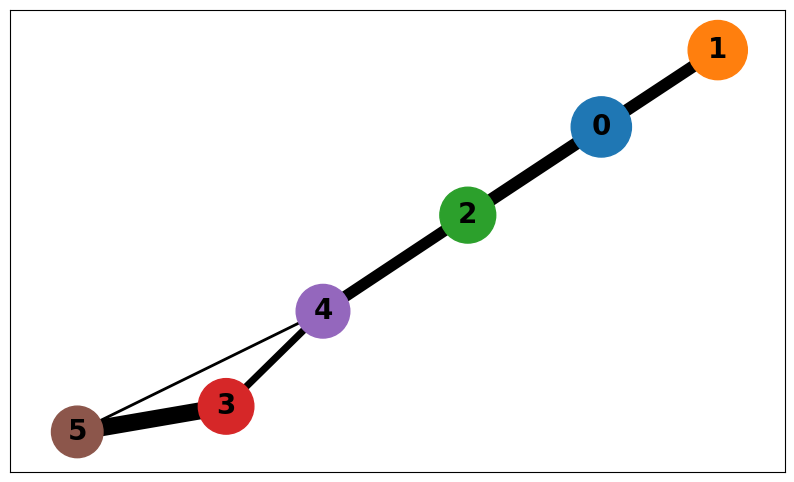

In [22]:
# Performing PAGA-based pseudotime time analysis
sc.tl.paga(adata_st,groups='ssgate_cluster',neighbors_key='SSGATE_neighbor')
# Create a spatial image and save it as a 300 DPI PNG
fig, ax = plt.subplots(figsize=(10, 6))
# Adjust the font and trackball size of the PAGA graph
sc.pl.paga(
    adata_st, color='ssgate_cluster',
    fontsize=20,  edge_width_scale = 3,       # Set the font size
    node_size_scale=10, ax=ax, show=False)
plt.savefig('paga_SCS_MT_SSGATE_leiden.pdf', dpi=300, format='PDF')

In [23]:
sc.tl.draw_graph(adata_st)

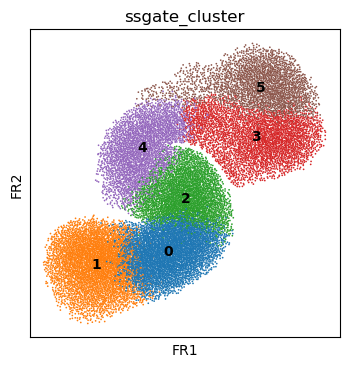

<Figure size 1200x200 with 0 Axes>

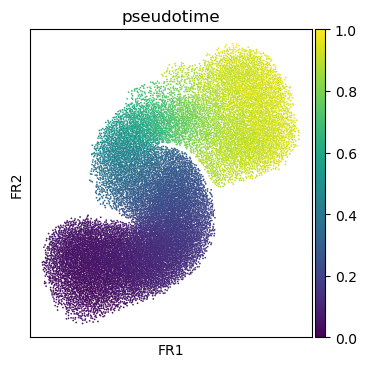

<Figure size 1200x200 with 0 Axes>

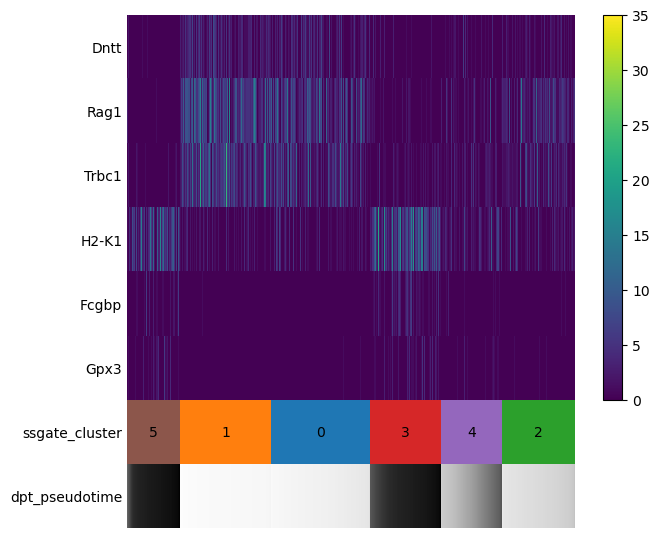

<Figure size 1200x200 with 0 Axes>

In [24]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Specifying pathways and gene lists
nodes_path = ['5', '1', '0', '3', '4', '2']
genes_of_interest = ["Dntt", "Rag1", "Trbc1", 'H2-K1', "Fcgbp", "Gpx3"]

# Try different root nodes
# Combined with GO enrichment analysis, 5 is the original node of T cell development
root_cells = ['1']  # Assume these are possible root nodes
for root_cell in root_cells:
    adata_st.uns['iroot'] = np.flatnonzero(adata_st.obs['ssgate_cluster'] == root_cell)[0]
    sc.tl.dpt(adata_st)
    
    # Draw graph for 'ssgate_cluster'
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.draw_graph(adata_st, color='ssgate_cluster', legend_loc='on data', title='ssgate_cluster', frameon=True, ax=ax)
    plt.savefig(f'_dpt_{root_cell}_ssgate_cluster.png')
    plt.close(fig)
    
    # Draw graph for 'dpt_pseudotime'
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.draw_graph(adata_st, color='dpt_pseudotime', legend_loc='on data', title='pseudotime', frameon=True, ax=ax)
    plt.savefig(f'_dpt_{root_cell}_dpt_pseudotime.png')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    sc.pl.paga_path(adata_st, nodes=nodes_path, keys=genes_of_interest, save=f'_paga_path_{root_cell}.png')
    plt.savefig(f'paga_path_{root_cell}.png')
    plt.close(fig)
